<a href="https://colab.research.google.com/github/farahwadya/Car-insurance-intermediate-machine-learning-project/blob/main/Car_insurance_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# upload packages

In [42]:
import pandas as pd
#split to train and test model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
set_config(transform_output='pandas')

# Dataset

In [43]:
fpath='/content/drive/MyDrive/AXSOSACADEMY/05-IntermediateML/Car_Insurance_Claim.csv'
df=pd.read_csv(fpath)
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [44]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


In [45]:
df.shape

(10000, 19)

In [46]:
df['OUTCOME'].unique()

array([0., 1.])

# Data cleaning

## Data type and inconsistent

In [47]:
print(df.dtypes)

ID                       int64
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object


### Age

In [48]:
df['AGE'].unique()

array(['65+', '16-25', '26-39', '40-64'], dtype=object)

In [49]:
age_map = {
    '16-25': 'Young',
    '26-39': 'Adult',
    '40-64': 'Middle-aged',
    '65+': 'Old'
}
df['AGE'] = df['AGE'].map(age_map)

In [50]:
df['AGE'].unique()

array(['Old', 'Young', 'Adult', 'Middle-aged'], dtype=object)

In [51]:
df['GENDER'].unique()

array(['female', 'male'], dtype=object)

In [52]:
df['RACE'].unique()

array(['majority', 'minority'], dtype=object)

In [53]:
df['DRIVING_EXPERIENCE'].unique()

array(['0-9y', '10-19y', '20-29y', '30y+'], dtype=object)

In [54]:
df['EDUCATION'].unique()

array(['high school', 'none', 'university'], dtype=object)

In [55]:
df['INCOME'].unique()

array(['upper class', 'poverty', 'working class', 'middle class'],
      dtype=object)

In [56]:
df['VEHICLE_YEAR'].unique()

array(['after 2015', 'before 2015'], dtype=object)

In [57]:
df['VEHICLE_TYPE'].unique()

array(['sedan', 'sports car'], dtype=object)

### Driving experience

In [58]:
experience_map = {
    '0-9y': 'Novice (0-9y)',
    '10-19y': 'Intermediate (10-19y)',
    '20-29y': 'Experienced (20-29y)',
    '30y+': 'Expert (30y+)'
}

df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].map(experience_map)

## null values

In [59]:
df.isna().sum()

,0
ID,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,982
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0


## duplicates

In [60]:
df.duplicated().sum()

np.int64(0)

# Exploration

In [61]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Old,female,majority,Novice (0-9y),high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Novice (0-9y),none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Novice (0-9y),high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Novice (0-9y),university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Adult,male,majority,Intermediate (10-19y),none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


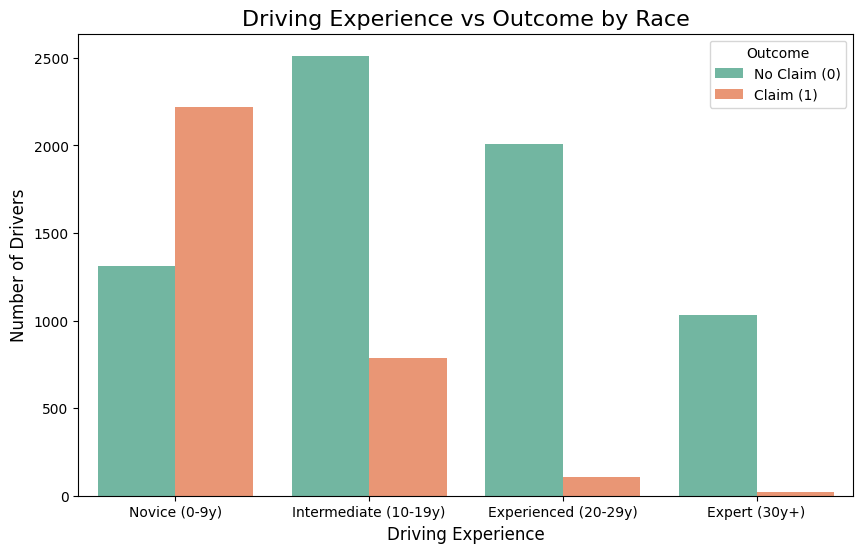

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10,6))

# Plot countplot: Driving Experience vs Outcome, colored by OUTCOME
sns.countplot(
    data=df,
    x='DRIVING_EXPERIENCE',
    hue='OUTCOME',
    palette='Set2',
    dodge=True
)

# Add title and axis labels
plt.title('Driving Experience vs Outcome by Race', fontsize=16)
plt.xlabel('Driving Experience', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

# Customize legend
plt.legend(title='Outcome', labels=['No Claim (0)', 'Claim (1)'])

# Show plot
plt.show()


This visualization shows that driving experience affects the insurance outcome. Novice drivers (0-9y) have the highest number of claims, while more experienced drivers (20-29y and 30y+) tend to have fewer claims. This indicates a negative correlation between driving experience and the likelihood of filing a claim.

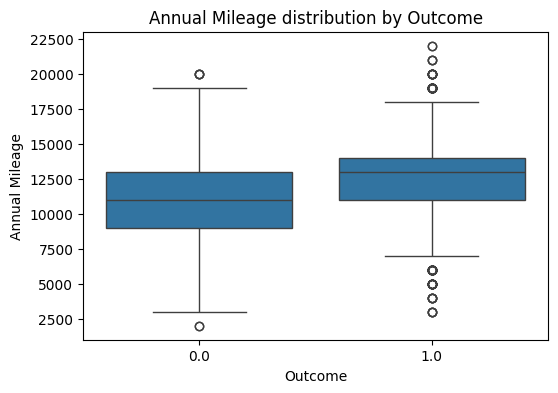

In [63]:
plt.figure(figsize=(6,4))
sns.boxplot(x='OUTCOME', y='ANNUAL_MILEAGE', data=df)
plt.xlabel('Outcome')
plt.ylabel('Annual Mileage')
plt.title('Annual Mileage distribution by Outcome')
plt.show()


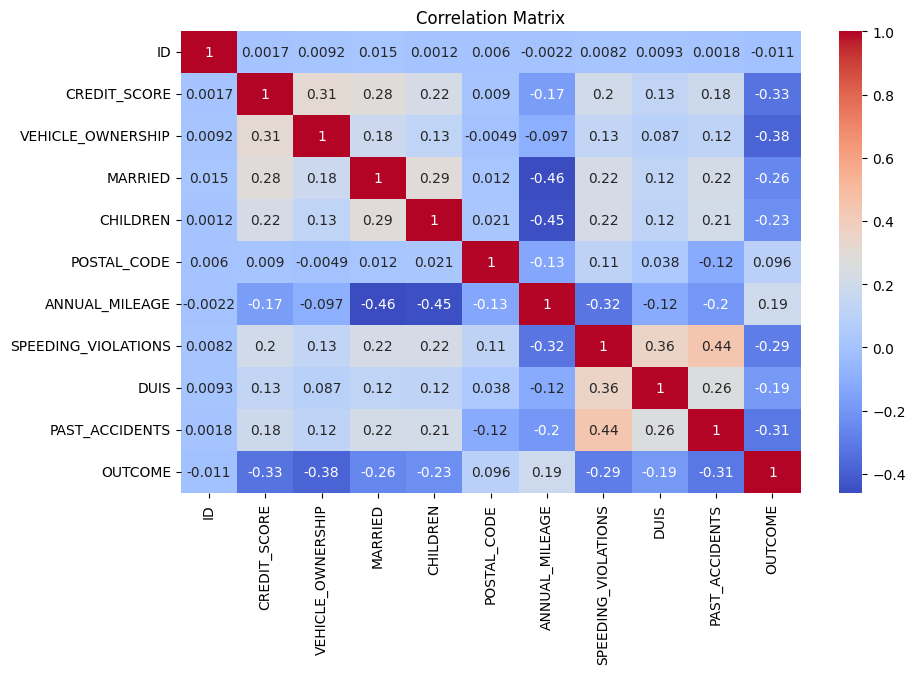

In [64]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


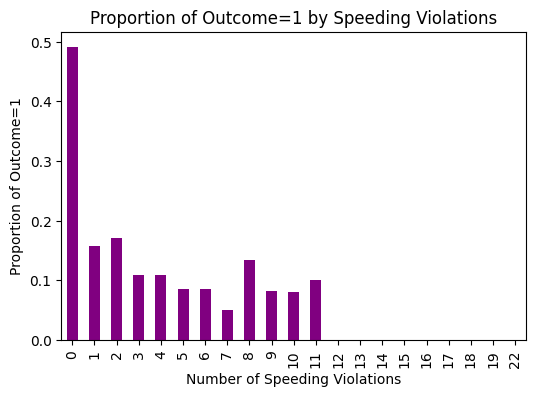

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# حساب النسبة لكل عدد مخالفات
summary = df.groupby('SPEEDING_VIOLATIONS')['OUTCOME'].mean()

plt.figure(figsize=(6,4))
summary.plot(kind='bar', color='purple')
plt.xlabel('Number of Speeding Violations')
plt.ylabel('Proportion of Outcome=1')
plt.title('Proportion of Outcome=1 by Speeding Violations')
plt.show()



In [66]:
# حساب العدد لكل فئة عمرية لكل Outcome
age_counts = df.groupby(['AGE', 'OUTCOME']).size().unstack(fill_value=0)

print(age_counts)


OUTCOME       0.0   1.0
AGE                    
Adult        2031  1032
Middle-aged  2474   457
Old          1794   196
Young         568  1448


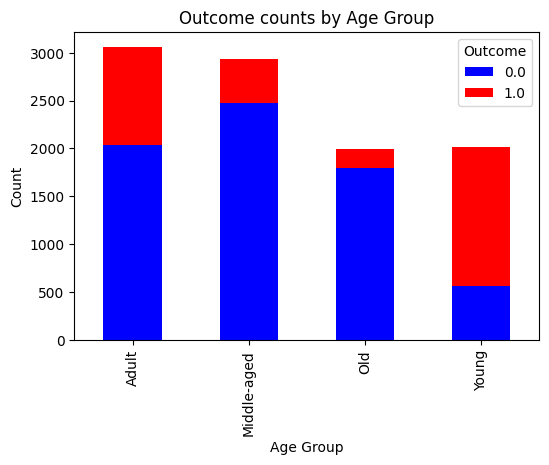

In [67]:
age_counts.plot(kind='bar', stacked=True, color=['blue','red'], figsize=(6,4))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Outcome counts by Age Group')
plt.legend(title='Outcome')
plt.show()


In [68]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Old,female,majority,Novice (0-9y),high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Novice (0-9y),none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Novice (0-9y),high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Novice (0-9y),university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Adult,male,majority,Intermediate (10-19y),none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [69]:
df['POSTAL_CODE'].unique()

array([10238, 32765, 92101, 21217])

# preprocessing

## train test split

In [70]:
#define target feature
y = df['OUTCOME']
X = df.drop(columns=['ID','OUTCOME'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## ord cols

In [71]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Old,female,majority,Novice (0-9y),high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Novice (0-9y),none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Novice (0-9y),high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Novice (0-9y),university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Adult,male,majority,Intermediate (10-19y),none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [72]:
ord_cols = ["DRIVING_EXPERIENCE",'AGE', 'EDUCATION', 'INCOME' ]
ord1=['Novice (0-9y)', 'Intermediate (10-19y)', 'Experienced (20-29y)',
       'Expert (30y+)']
ord2=['Young', 'Adult', 'Middle-aged', 'Old']
ord3=['none','high school',  'university']
ord4=['poverty','working class', 'middle class','upper class'  ]
ordinal=OrdinalEncoder(categories=[ord1,ord2,ord3,ord4])
scaler=StandardScaler()
impute_missing=SimpleImputer(strategy='most_common')
ord_pipe=make_pipeline(impute_missing,ordinal,scaler)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_common')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Novice (0-9y)',
                                             'Intermediate (10-19y)',
                                             'Experienced (20-29y)',
                                             'Expert (30y+)'],
                                            ['Young', 'Adult', 'Middle-aged',
                                             'Old'],
                                            ['high school', 'none',
                                             'university'],
                                            ['upper class', 'poverty',
                                             'working class',
                                             'middle class']])),
                ('standardscaler', StandardScaler())])

In [73]:
ord_tuple=('ordinal',ord_pipe,ord_cols)

In [74]:
df['INCOME'].unique()

array(['upper class', 'poverty', 'working class', 'middle class'],
      dtype=object)

## cat cols

In [75]:
cat_cols=X_train.select_dtypes(include='object').drop(columns=ord_cols).columns
cat_cols

Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object')

In [76]:
impute_cat=SimpleImputer(strategy='constant',fill_value='MISSING')
one_hot=OneHotEncoder(handle_unknown='ignore',sparse_output=False)
cat_pipe=make_pipeline(impute_cat,one_hot)
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [77]:
cat_tuple=('categorical',cat_pipe,cat_cols)

## num_cols

In [78]:
num_cols=X_train.select_dtypes(include='number').columns
num_cols

Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')

In [79]:
impute_num=SimpleImputer(strategy='median') # imputing with median as there are some outliers, so the mean would be affected by
num_pipe=make_pipeline(impute_num,scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [80]:
num_tuple=('numeric',num_pipe,num_cols)

## col transformer

In [81]:
preprocessor = ColumnTransformer(
    transformers=[cat_tuple,ord_tuple,num_tuple],remainder='passthrough',
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimpu...
                                 ['DRIVING_EXPERIENCE', 'AGE', 'EDUCATION',
                                  'INCOME']),
                                ('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [82]:
X_train_tf=preprocessor.fit_transform(X_train)
X_train_tf()

InvalidParameterError: The 'strategy' parameter of SimpleImputer must be a str among {'mean', 'most_frequent', 'median', 'constant'} or a callable. Got 'most_common' instead.

In [ ]:
print("Ordinal:", ord_cols)
print("Categorical:", cat_cols.columns.tolist())
print("Numeric:", num_cols.columns.tolist())


# modeling

## Random Forest classifier

In [ ]:
rf_clf=RandomForestClassifier(random_state=42)